In [20]:
import nltk
import pandas as pd
# Do our imports for the code
from google.cloud import bigquery
from google.oauth2 import service_account
from collections import Counter
from nltk.corpus import stopwords
words = set(nltk.corpus.words.words())
sw2=set(stopwords.words('english'))
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt

In [2]:
# Set authentication info
service_path = "/Users/natebender/Desktop/repo/footprints/footprints_audience/"
service_file = 'footprintsrunning-d15e651db9a6.json' # change this to your authentication information  
gbq_proj_id = 'footprintsrunning' # change this to your poroject. 

# And this should stay the same. 
private_key = service_path + service_file

# Now we pass in our credentials so that Python has permission to access our project.
credentials = service_account.Credentials.from_service_account_file(service_path + service_file)

# And finally we establish our connection
gbqclient = bigquery.Client(credentials = credentials, project=gbq_proj_id)

In [3]:
table_id = 'footprintsrunning.twitter_scraping.trail_running'

In [4]:
table = gbqclient.get_table(table_id)  # Make an API request.

# View table properties
print(
    "Got table '{}.{}.{}'.".format(table.project, table.dataset_id, table.table_id)
)
print("Table schema: {}".format(table.schema))
print("Table description: {}".format(table.description))
print("Table has {} rows".format(table.num_rows))

Got table 'footprintsrunning.twitter_scraping.trail_running'.
Table schema: [SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('screen_name', 'STRING', 'NULLABLE', None, (), None), SchemaField('location', 'STRING', 'NULLABLE', None, (), None), SchemaField('friends_count', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('followers_count', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('totaltweets', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('date_created', 'STRING', 'NULLABLE', None, (), None), SchemaField('tweet_id', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('retweetcount', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('full_text', 'STRING', 'NULLABLE', None, (), None), SchemaField('fulltext_clean', 'STRING', 'NULLABLE', None, (), None), SchemaField('desc_clean', 'STRING', 'NULLABLE', None, (), None)]
Table description: None
Table has 89354 rows


### Analysis playing around

In [5]:
# code I don't fully understand for setting up GBQ querying

import pydata_google_auth
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    # Set auth_local_webserver to True to have a slightly more convienient
    # authorization flow. Note, this doesn't work if you're running from a
    # notebook on a remote sever, such as over SSH or with Google Colab.
    auth_local_webserver=True,
)

In [6]:
# query GBQ table and place data into pandas df

query = """
    SELECT 
    screen_name,
    desc_clean,
    fulltext_clean
    FROM
    `footprintsrunning.twitter_scraping.trail_running`
"""

data = pd.read_gbq(query, project_id = gbq_proj_id, credentials=credentials, dialect = 'standard')


In [7]:
len(data)

89354

In [8]:
# experiment on smaller sample for starters

df_sample = data.sample(n=2000)

In [9]:
df_sample.head(10)

,screen_name,desc_clean,fulltext_clean
83990,esquireattire,fashion style accessories sunglasses shoes mod...,asics men tank athletic top size stay
31621,therunningmanc,danny mcr raised 5k charity 2020 21 team chall...,nutrition recommendations brands like use rout...
12188,kjellouise,,morning runs riviera
56593,mk_marathon,looking forward welcoming multi award winning ...,ben norman run 10 x mk marathons amazing achie...
19691,CodelibApp,discover 38 000 scripts plugins code 2 unique ...,retro speed html5 game mobile version construc...
86560,tbwUltraPowers,,5 wet five kilometres completed
44348,LouiseKelowna,,coming monday
26966,BoyUnfit,upon time long ago getting old hurry stopped h...,new year approaches one moves forward eager mo...
43475,eddietheaker,retired fire service enjoying new lease life,gentle 10k morning weather lot better legs bit...
78699,ThatGuyRalphie,anybody worth time convinced,enjoying mountain trails


In [10]:
# extract tweets into dedicated variable
tweets = [df_sample['fulltext_clean'] 
                 for i in df_sample ]

In [11]:
# Check desc stats on overall descriptions before splitting into groups
def get_patterns(text) :

    all_desc = text
    all_str = " ".join(all_desc[0])    
    clean = [w for w in all_str.split()]
    
    # Calculate your statistics here
    total_tokens = len(clean)
    unique_tokens = len(set(clean))
    clean_tok_len = [len(w) for w in clean]
    avg_token_len = np.mean(clean_tok_len)
    lex_diversity = len(set(clean))/len(clean)
    top_n = Counter(clean).most_common(20)
    
    
    # Now we'll fill out the dictionary. 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':round(avg_token_len,2),
               'lexical_diversity':round(lex_diversity,2),
               'Top_n':top_n}

    return(results)

In [12]:
get_patterns(tweets)

{'tokens': 21375,
 'unique_tokens': 5489,
 'avg_token_length': 5.15,
 'lexical_diversity': 0.26,
 'Top_n': [('run', 478),
  ('running', 280),
  ('day', 203),
  ('amp', 192),
  ('morning', 166),
  ('today', 154),
  ('2022', 147),
  ('new', 137),
  ('miles', 136),
  ('year', 117),
  ('time', 112),
  ('get', 107),
  ('good', 106),
  ('2', 105),
  ('first', 98),
  ('5', 97),
  ('like', 88),
  ('1', 87),
  ('one', 82),
  ('go', 80)]}

In [13]:
# extract desc into dedicated variable
desc = [df_sample['desc_clean'] 
                 for i in df_sample ]

In [14]:
descdict = get_patterns(desc)

### Viz exploration

In [15]:
keys = descdict.keys()
values = list(descdict.values())
topn = values[4]

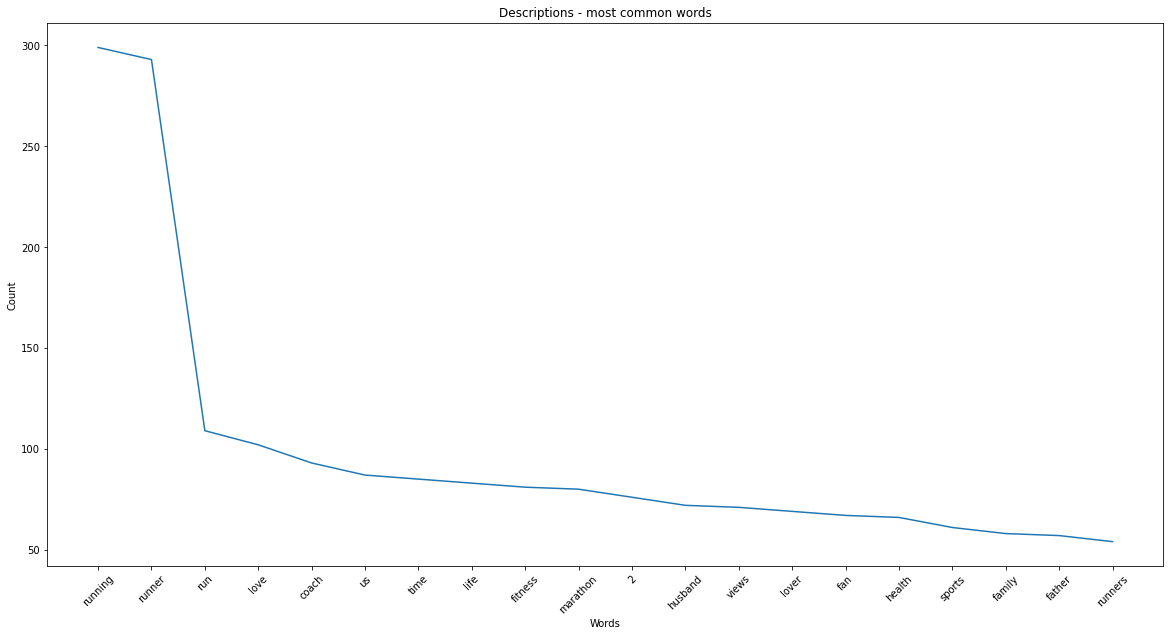

In [16]:
xs = [x for x, y in topn]
ys = [y for x, y in topn]

fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(xs, ys)
plt.setp(ax.get_xticklabels(), rotation = 45)

ax.set(title = "Descriptions - most common words",
       xlabel = "Words",
       ylabel = "Count")

plt.show()

In [17]:
tweetdict = get_patterns(tweets)

In [18]:
keys = tweetdict.keys()
values = list(tweetdict.values())
topn = values[4]

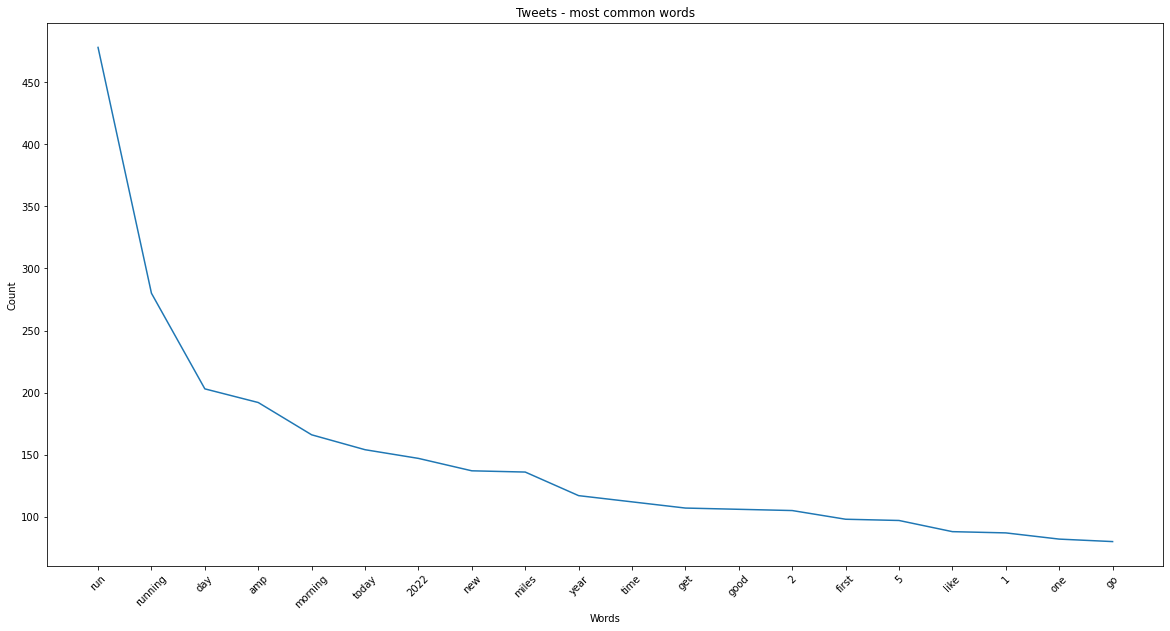

In [19]:
xs = [x for x, y in topn]
ys = [y for x, y in topn]

fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(xs, ys)
plt.setp(ax.get_xticklabels(), rotation = 45)

ax.set(title = "Tweets - most common words",
       xlabel = "Words",
       ylabel = "Count")

plt.show()

### Top 1% most-followed accounts

In [22]:
# query GBQ table and place data into pandas df

query = """
    SELECT 
    screen_name,
    followers_count,
    retweetcount,
    location
    FROM
    `footprintsrunning.twitter_scraping.trail_running`
"""

df_follow = pd.read_gbq(query, project_id = gbq_proj_id, credentials=credentials, dialect = 'standard')

In [51]:
# filter to only accounts with top 1% of followers
top = df_follow[df_follow.followers_count > np.percentile(df_follow.followers_count,99)]

# remove duplicates, display in descending order by follower count
top[['screen_name', 'followers_count']].drop_duplicates(subset=['screen_name']).sort_values(by=['followers_count'], ascending=False)


,screen_name,followers_count
79522,AppleMusic,9978054
88100,USArmy,1769384
2679,Bybit_Official,936557
49916,RebeccaMinkoff,874588
65100,MPTourism,594131
...,...,...
80300,inov_8,32604
74307,pcs_union,31844
65770,SOLETRADER,31001
58750,TimIzCocky,30962
